In [1]:
# Colab Setup (Run this first)

In [2]:
!pip install litebird_sim rich

# `litebird_sim` scan map


To run this notebook, you have several options:

-   If you are running this under Binder, you should already be set!
-   If you are running this under Google Colab, be sure to run the cell with `!pip install…` that is right above the title.
-   If you are running this locally, you should first create and activate a new virtual environment with the commands

    ```
    python -m venv ./my_venv
    source ./my_venv/bin/activate
    ```

    (you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

    ```
    pip install jupyter litebird_sim
    ```

    If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a _development install_ instead:

    ```
    cd /my/local/copy/litebird_sim
    pip install -e .
    ```


## Set up the environment


In [3]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide

We start by importing a few libraries that will be useful in this notebook.


In [4]:
import litebird_sim as lbs
import numpy as np

import matplotlib.pylab as plt
import astropy

import inspect

%matplotlib inline

In [5]:
lbs.PTEP_IMO_LOCATION

PosixPath('/Users/luca/Documents/Universita/litebird/simteam/codes/litebird_sim/litebird_sim/default_imo/schema.json.gz')

## Parameters of the simulation

We will simulate a pair of 140 GHz LFT detectors. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version vPTEP (**new!**), and we will simulate 6 months of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.


In [6]:
telescope = "LFT"
channel = "L4-140"
detlist = [
    "000_001_017_QB_140_T",
    "000_001_017_QB_140_B",
]

start_time = astropy.time.Time("2025-01-01T00:00:00")
mission_time_days = 180

imo_version = "vPTEP"

# Resolution of the output maps
nside = 64

To use the IMO bundled in `litebird_sim`, one needs to do the following:


In [7]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    imo=imo,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
    random_seed=12345,  # seed for the random number generator (MANDATORY parameter!!!)
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.


In [8]:
# Load the definition of the instrument (MFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

# filling dets with info and detquats with quaternions of the detectors in detlist
dets = []  # type: List[lbs.DetectorInfo]
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )

    # we overwrite the nominal sampling rate read from IMO with a smaller one, so that
    # we produce 12 months tod without taking too much memory
    det.sampling_rate_hz = 2

    dets.append(det)

The following command will take some time: it needs to compute the ephemerides of the Earth with respect to the Ecliptic reference frame and derive the orientation of the LFT instrument as a function of time for the whole duration of the simulation. This step will be needed later, when we will obtain the pointings for the detectors involved in the simulation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/scanning.html#scanning-strategy) for more details about the scanning strategy.


In [9]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

## Initialize TODs

Let's now create a set of «[observations](https://litebird-sim.readthedocs.io/en/latest/observations.html#observations)». This concept was mutuated by [TOAST](https://github.com/hpc4cmb/toast), and it represents a chunk of data acquired while the instrument was in almost stable conditions (i.e., stationary noise, no thermal drifts…). For the sake of simplicity, we create just _one_ observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.

The method create_observations allows to specify the data type of the allocated TOD with tod_dtype

In [10]:
sim.create_observations(
    detectors=dets, n_blocks_det=1, n_blocks_time=1, tod_dtype=np.float32
)

It is also possible to create several TODs using the same method

In [11]:
(obs,) = sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,
    tods=[
        lbs.TodDescription(
            name="cmb_signal",
            description="CMB",
            dtype=np.float64,
            units=lbs.Units.K_CMB,
        ),
        lbs.TodDescription(
            name="fg_signal",
            description="FG",
            dtype=np.float64,
            units=lbs.Units.K_CMB,
        ),
        lbs.TodDescription(
            name="noise",
            description="1/f+white noise",
            dtype=np.float32,
            units=lbs.Units.K_CMB,
        ),
    ],
)

[2026-01-20 16:48:23,446 WARNING MPI#0000] Detector layer is already initialized. Reinitializing the entire RNG hierarchy.


In [12]:
print(obs.cmb_signal.shape)
print(obs.fg_signal.shape)
print(obs.noise.shape)

print(obs.cmb_signal.dtype)
print(obs.fg_signal.dtype)
print(obs.noise.dtype)

(2, 31104000)
(2, 31104000)
(2, 31104000)
float64
float64
float32


Let's now compute the pointings, in this case we do not initialize the HWP


In [13]:
sim.prepare_pointings()
sim.precompute_pointings()

## Generate inputs

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the [frequency channel](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) we are simulating (140 GHz), so we retrieve them from the IMO again:


In [14]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

The LiteBIRD Simulation Framework provides a class [SkyGenerator](https://litebird-sim.readthedocs.io/en/latest/sky_maps.html), which is a wrapper to PySM; we use it to produce a map of the sky including synchrotron, free-free, and dust, and we smooth the map according to the FWHM specified in the IMO. (Note that we do not need to pass this information explicitly, as SkyGenerator is able to extract it from `ch_info`.)

In [15]:
# let's make an input CMB map

# this sets the parameters for the generation of the map
sky_params = lbs.SkyGenerationParams(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,  # set this seed if you want to fix the CMB realization
    apply_beam=True,  # if True, smooths the input map by the beam of the channel
    bandpass_integration=False,  # if True, integrates over the top-hat bandpass of the channel
    units="K_CMB",
    output_type="map",
    nside=nside,
)

cmb_sky = sim.get_sky(parameters=sky_params, channels=ch_info)

# and a FG map
sky_params = lbs.SkyGenerationParams(
    make_cmb=False,
    make_fg=True,
    fg_models=["s0", "f1", "d0"],  # set the FG models you want
    apply_beam=True,  # if True, smooths the input map by the beam of the channel
    bandpass_integration=False,  # if True, integrates over the top-hat bandpass of the channel
    units="K_CMB",
    output_type="map",
    nside=nside,
)

fg_sky = sim.get_sky(parameters=sky_params, channels=ch_info)

[2026-01-20 16:48:27,378 INFO MPI#0000] Generating CMB...
[2026-01-20 16:48:27,422 INFO MPI#0000] Summing components...
[2026-01-20 16:48:27,424 WARNING MPI#0000] seed_cmb is None. This could lead to unexpected behavior in MPI jobs.
[2026-01-20 16:48:27,424 INFO MPI#0000] Generating Foregrounds...
[2026-01-20 16:48:27,426 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2026-01-20 16:48:27,453 INFO MPI#0000] NSIDE = 512
[2026-01-20 16:48:27,455 INFO MPI#0000] ORDERING = RING in fits file
[2026-01-20 16:48:27,455 INFO MPI#0000] INDXSCHM = IMPLICIT
[2026-01-20 16:48:27,540 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2026-01-20 16:48:27,543 INFO MPI#0000] NSIDE = 512
[2026-01-20 16:48:27,544 INFO MPI#0000] ORDERING = RING in fits file
[2026-01-20 16:48:27,545 INFO MPI#0000] INDXSCHM = IMPLICIT
[2026-01-20 16:48:27,633 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2026-01-20 16:48:27,

## Fill TODs

Now we can fill the TODs with the appropriate sky signal. This is done using the `Simulation.fill_tods` method, which internally selects one of three different algebraic models depending on the HWP configuration.

Three available TOD signal models:
1. No HWP:

   $$ d_t = T + \gamma \left(Q\cos(2\theta + 2\psi_t)+U\sin(2\theta + 2\psi_t)\right), $$

where $\theta$ is the polarization angle of the detecotor, $\psi_t$
is the orientation of the telescope at the time $t$, and $\gamma$
is the polarization efficiency.

2. Ideal HWP:

   $$ d_t = T + \gamma \left(Q\cos(4\alpha_t - 2\theta + 2\psi_t)+U\sin(4\alpha_t - 2\theta + 2\psi_t)\right), $$

where $\alpha_t$ is the HWP angle at the time $t$.

3. Generic HWP:

   $$ d_t = (1,0,0,0) \times M_{\rm pol} \times R(\theta) \times R^T(\alpha_t) \times M_{\rm HWP} \times R(\alpha_t) \times R(\psi_t) \times \vec{S}, $$

where
   - $M_{\rm pol}$ is mueller matrix of the polarimeter;
   - $M_{\rm HWP}$ is mueller matrix of the HWP;
   - $R$ is a rotation matrix;
   - $\vec{S}$ is the Stokes vector.
   
   
The `fill_tods` method selects the correct equation automatically, based on how the simulation has been configured:
The proper algebra is used based on the settings of the simulation:

- Equation 1 is used if no HWP is defined.

- Equation 2 is used if an ideal HWP is set.

- Equation 3 is used if a Mueller matrix is provided, either per channel or per detector.

The signature of `Simulation.fill_tods` is quite simple

In [16]:
sig = inspect.signature(sim.fill_tods)
for param in sig.parameters.values():
    print(param)

maps: litebird_sim.maps_and_harmonics.HealpixMap | dict[str, litebird_sim.maps_and_harmonics.HealpixMap] | litebird_sim.maps_and_harmonics.SphericalHarmonics | dict[str, litebird_sim.maps_and_harmonics.SphericalHarmonics] | None = None
component: str = 'tod'
pointings_dtype=<class 'numpy.float64'>
append_to_report: bool = True
nthreads: int | None = None


Parameters: 
- `input_map_in_galactic` allows to specify the coordinates of the input maps. Default: Galactic

- `component` allows to specify to which TOD you want sum the scanned map. Default: tod

- `pointings_dtype` allows to specify the type of the pointing generated on the fly. Default: float64

`Simulation.fill_tods()` is a wrapper around a lower level function called `litebird_sim.scan_map_in_observations`.

Their signature is very similar, `scan_map_in_observations` allows for a more refined handling of the inputs. 
You can pass it any sub-set of the observations, a different pointings object or a different HWP object 

In [17]:
sig = inspect.signature(lbs.scan_map_in_observations)
for param in sig.parameters.values():
    print(param)

observations: litebird_sim.observations.Observation | list[litebird_sim.observations.Observation]
maps: litebird_sim.maps_and_harmonics.HealpixMap | dict[str, litebird_sim.maps_and_harmonics.HealpixMap] | litebird_sim.maps_and_harmonics.SphericalHarmonics | dict[str, litebird_sim.maps_and_harmonics.SphericalHarmonics] | None = None
pointings: numpy.ndarray | list[numpy.ndarray] | None = None
hwp: litebird_sim.hwp.HWP | None = None
component: str = 'tod'
pointings_dtype: numpy.dtype = <class 'numpy.float64'>
save_tod: bool = True
apply_non_linearity: bool = False
add_2f_hwpss: bool = False
mueller_phases: numpy.ndarray | None = None
comm: bool | None = None
nthreads: int | None = None


The method `scan_map_in_observations` is built on top of a lower-level function called `scan_map`, which operates directly on individual TODs and offers maximum flexibility.

In [18]:
sig = inspect.signature(lbs.scan_map)
for param in sig.parameters.values():
    print(param)

tod
pointings
maps: litebird_sim.maps_and_harmonics.HealpixMap | dict[str, litebird_sim.maps_and_harmonics.HealpixMap] | litebird_sim.maps_and_harmonics.SphericalHarmonics | dict[str, litebird_sim.maps_and_harmonics.SphericalHarmonics]
pol_angle_detectors: numpy.ndarray | None = None
pol_eff_detectors: numpy.ndarray | None = None
hwp: litebird_sim.hwp.HWP | None = None
hwp_angle: numpy.ndarray | None = None
mueller_hwp: numpy.ndarray | None = None
input_names: str | None = None
interpolation: str | None = ''
pointings_dtype=<class 'numpy.float64'>
nthreads: int = 0


Let's see how to use them

### No HWP

In the simplest case no HWP is initialized in the simulation. The algebra implemented is:

$ d_t = T + \gamma \left(Q\cos(2\theta + 2\psi_t)+U\sin(2\theta + 2\psi_t)\right)$

$\psi_t$ is the pointing information and the polarization angle $\theta$ are taken from the detector information stored in the observation

In [19]:
# polarization angle
print(obs.pol_angle_rad.shape)
# pointing
print(obs.pointing_matrix.shape)

(2,)
(2, 31104000, 3)


In [20]:
# Let's use cmb_sky for the TOD cmb_signal
sim.fill_tods(cmb_sky, component="cmb_signal")

print(obs.cmb_signal)
print(obs.fg_signal)

[[ 1.89746244e-05  1.89739963e-05  1.89733497e-05 ... -1.06287007e-05
  -1.06296972e-05 -1.06306854e-05]
 [ 1.61326945e-05  1.61327535e-05  1.61328315e-05 ... -9.33349025e-06
  -9.33222859e-06 -9.33097450e-06]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
# and the foreground for fg_signal
sim.fill_tods(fg_sky, component="fg_signal")

print(obs.cmb_signal)
print(obs.fg_signal)

[[ 1.89746244e-05  1.89739963e-05  1.89733497e-05 ... -1.06287007e-05
  -1.06296972e-05 -1.06306854e-05]
 [ 1.61326945e-05  1.61327535e-05  1.61328315e-05 ... -9.33349025e-06
  -9.33222859e-06 -9.33097450e-06]]
[[7.57204773e-05 7.57311006e-05 7.57416705e-05 ... 9.76879208e-04
  9.76858320e-04 9.76837404e-04]
 [6.93214366e-05 6.93095292e-05 6.92976717e-05 ... 9.75139919e-04
  9.75160455e-04 9.75181028e-04]]


### Ideal HWP

When an ideal HWP (Half-Wave Plate) is initialized in the simulation, the following algebra is used to compute the TOD:

$ d_t = T + \gamma \left(Q\cos(4\alpha_t - 2\theta + 2\psi_t)+U\sin(4\alpha_t - 2\theta + 2\psi_t)\right) $

$\psi_t$ and $\alpha_t$ are respectively the pointing information and the HWP angle, again the polarization angle $\theta$ per detector is taken from observation

Now let’s initialize the HWP and set up the observation again.

In [22]:
(obs,) = sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,
)

sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # sets the hwp
)
sim.prepare_pointings()
sim.precompute_pointings()

[2026-01-20 16:48:47,342 WARNING MPI#0000] Detector layer is already initialized. Reinitializing the entire RNG hierarchy.


In [23]:
obs.mueller_hwp
# sim.nullify_tod?

array([[[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  0.],
        [ 0.,  0.,  0., -1.]],

       [[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  0.],
        [ 0.,  0.,  0., -1.]]])

In [24]:
sim.fill_tods(cmb_sky)

### Non-ideal HWP

When an non-ideal HWP is initialized in the simulation, the following algebra is used to compute the TOD:

$ d_t = (1,0,0,0) \times M_{\rm pol} \times R(\theta) \times R^T(\alpha_t) \times M_{\rm HWP} \times R(\alpha_t) \times R(\psi_t) \times \vec{S}, $

where
   - $M_{\rm pol}$ is mueller matrix of the polarimeter;
   - $M_{\rm HWP}$ is mueller matrix of the HWP;
   - $R$ is a rotation matrix;
   - $\vec{S}$ is the Stokes vector.
   
Now let’s initialize the HWP and set up the observation again.
Here in the initialization we specify a different mueller hwp per detector

In [25]:
dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )

    det.sampling_rate_hz = 2
    det.mueller_hwp = np.random.normal(0, 1, (4, 4))

    dets.append(det)

(obs,) = sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,
)

sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # sets the hwp
)
sim.prepare_pointings()
sim.precompute_pointings()

[2026-01-20 16:48:59,901 WARNING MPI#0000] Detector layer is already initialized. Reinitializing the entire RNG hierarchy.


In [26]:
sim.fill_tods(cmb_sky)

### Interpolation

The code supports also direct interpolation of the input alms when scanning them, using [synthesis_general](https://mtr.pages.mpcdf.de/ducc/sht.html#ducc0.sht.synthesis_general) of ducc0.

In [27]:
# this sets the parameters for the generation of the alms
sky_params = lbs.SkyGenerationParams(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,  # set this seed if you want to fix the CMB realization
    apply_beam=True,  # if True, smooths the input map by the beam of the channel
    bandpass_integration=False,  # if True, integrates over the top-hat bandpass of the channel
    units="K_CMB",
    output_type="alm",
    nside=nside,
)

alm_cmb_sky = sim.get_sky(parameters=sky_params, channels=ch_info)

[2026-01-20 16:49:11,955 INFO MPI#0000] Generating CMB...
[2026-01-20 16:49:12,000 INFO MPI#0000] Summing components...


In [28]:
dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = 2
    dets.append(det)

(obs,) = sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,
    tods=[
        lbs.TodDescription(
            name="tod",
            description="CMB",
            dtype=np.float64,
            units=lbs.Units.K_CMB,
        ),
        lbs.TodDescription(
            name="tod_interpolated",
            description="CMB iterpolated",
            dtype=np.float64,
            units=lbs.Units.K_CMB,
        ),
    ],
)

sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # sets the hwp
)
sim.prepare_pointings()
sim.precompute_pointings()

[2026-01-20 16:49:12,012 WARNING MPI#0000] Detector layer is already initialized. Reinitializing the entire RNG hierarchy.


In [29]:
sim.fill_tods(cmb_sky, component="tod")
sim.fill_tods(alm_cmb_sky, component="tod_interpolated")

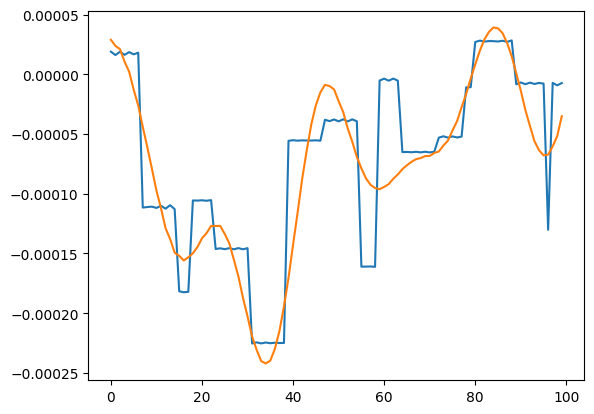

In [30]:
plt.plot(obs.tod[0, 0:100])
plt.plot(obs.tod_interpolated[0, 0:100])